# Which IDR peak is captured in oligoCLIP?
- does `l2FC`/`RPKM` predicts what IDR peaks gonna be re-captured in a shallowed sequenced dataset

In [1]:
import sys
sys.path.append('/home/hsher/Metadensity/scripts')
from dataloader import *
import matplotlib.pyplot as plt
from pybedtools import BedTool
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline
import seaborn as sns
from pybedtools import BedTool
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# loading IDR peaks
k562_idr = BedTool(encode_data.loc[encode_data['uid']=='676', 'idr'].iloc[0])
hek_idr = BedTool('/home/hsher/scratch/oligoIDR/nature_rbfox2/results/NATURE2016_RBFOX2_rep2.vs.NATURE2016_RBFOX2_rep1.bed')

In [3]:
rna_expression = pd.read_csv('/home/hsher/projects/Metadensity_notebooks/bind_site_finder/CCLE_RNAseq_genes_rpkm_20180929.tsv', sep = '\t', skiprows = 2, index_col = 1)
rna_expression = rna_expression.reset_index().drop_duplicates(subset = ['Description']).set_index('Description')

In [4]:
[c for c in rna_expression.columns if 'HEK' in c]

['HEKTE_KIDNEY']

In [5]:
column = 'HEK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE'

In [6]:
coord = BedTool('/home/hsher/gencode_coords/gencode.v35.basic.annotation.gff3')
genes = coord.filter(lambda i: i[2]=='gene' 
                     and i.attrs['gene_type']=='protein_coding'
                    and i.attrs['gene_name'] in rna_expression.index).saveas()

In [7]:
def annotate_IDR_with_RPKM(idr, cell_line_column, 
                           genes = genes, rna_expression = rna_expression,
                          rpkm_bins = [0,0.01,0.1,1,5,10,50,100,1000],
                           l2fc_bins = [0,1,3,5,10,20,50]
                          
                          ):
    ''' annotate IDR peaks with RPKM and l2FC'''
    idr_w_gene = idr.intersect(genes, s = True, wb = True).to_dataframe(
        names = ['chrom', 'start', 'end', 'l2fc', 'pval', 'strand',
                'chrom1', 'type', '.', 'start1', 'end1', '-', 'strand1', '/', 'attr'
                ])[['chrom', 'start', 'end','l2fc', 'pval', 'strand','attr']]
    idr_w_gene['gene_name'] = idr_w_gene['attr'].str.split('gene_name=', expand = True)[1].str.split(';', expand = True)[0]
    idr_w_gene['rpkm'] = idr_w_gene['gene_name'].map(rna_expression[cell_line_column])
    
    idr_w_gene.dropna(subset = ['rpkm'], inplace = True)
    
    # bin IDR by rpkm or L2FC
    idr_w_gene['rpkm_bins'] = pd.cut(idr_w_gene['rpkm'], bins = rpkm_bins)
    idr_w_gene['l2fc_bins'] = pd.cut(idr_w_gene['l2fc'], bins = l2fc_bins)
    
    return idr_w_gene

def capture_rate_by_bin(idr, bed, to_bin = 'rpkm_bins'):
    '''estimate capture rate by binning'''
    data = []
    for name, group in idr.groupby(by = to_bin):
        group_bed = BedTool.from_dataframe(group)
        captured = len(group_bed.intersect(bed, s = True, u = True))
        
        data.append([name, captured, group.shape[0]])
    data = pd.DataFrame(data, columns = [to_bin, 'n_captured', 'total'])
    data['capture_rate'] = data['n_captured']/data['total']
    return data

In [8]:
k562_idr_annot = annotate_IDR_with_RPKM(k562_idr,  'K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE')
hek_idr_annot = annotate_IDR_with_RPKM(hek_idr,  'HEKTE_KIDNEY')

In [9]:
k562_idr_annot.shape

(3095, 11)

In [10]:
hek_idr_annot.shape

(7178, 11)

<AxesSubplot:xlabel='l2fc', ylabel='rpkm'>

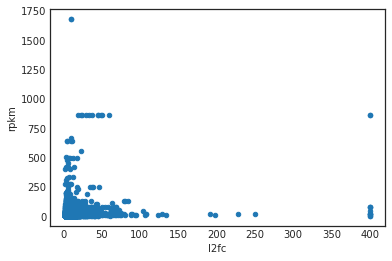

In [11]:
# IDR peak l2FC score is poorly correlated with RPKM
k562_idr_annot.plot.scatter(x = 'l2fc', y = 'rpkm')

<AxesSubplot:xlabel='l2fc', ylabel='rpkm'>

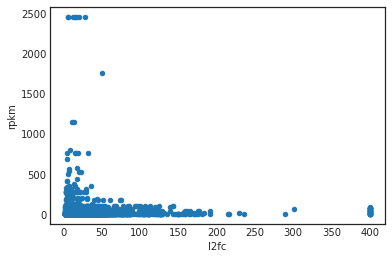

In [12]:
hek_idr_annot.plot.scatter(x = 'l2fc', y = 'rpkm')

# load datasets

In [13]:
nature=pd.read_csv('/home/hsher/projects/oligo_results/nature2016_hek_full.csv')
katie=pd.read_csv('/home/hsher/projects/oligo_results/katie_full.csv')
dan=pd.read_csv('Dan_full_data.csv')
encode_rbps=pd.read_csv('ENCODE_reprocess.csv')
# downsampled
all_data = pd.read_csv('all_data.csv')

In [14]:
all_rbfox = pd.concat([nature.loc[nature['RBP']=='RBFOX2'],
             katie.loc[katie['RBP']=='RBFOX2'],
             dan.loc[dan['RBP']=='RBFOX2'],
             encode_rbps.loc[encode_rbps['RBP']=='RBFOX2']],
                      axis = 0)

# to the same number of UMI

/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib

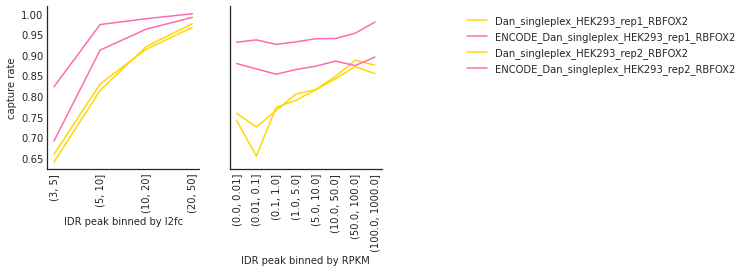

In [15]:

peaks = all_data.loc[(all_data['uid'].str.contains('RBFOX2'))
                               &(all_data['uid'].str.contains('HEK'))
                              &(all_data['uid'].str.contains('singleplex'))]

f, ax = plt.subplots(1,2,figsize = (6,3), sharey = True)
binning = 'l2fc_bins'
for index, row in peaks.iterrows():
    try:
        bed = BedTool(row['bed_0']).filter(lambda x: float(x[3])>3).saveas()
        data = capture_rate_by_bin(hek_idr_annot, bed, to_bin = binning)
        color = 'hotpink' if 'ENCODE' in row['uid'] else 'gold'
        cap_rate = data.set_index(binning)['capture_rate'].dropna()
        cap_rate.plot(label = row['uid'], color = color, ax = ax[0])
        
    except Exception as e:
        print(e)
#ax[0].legend(bbox_to_anchor = (1.5,1))
ax[0].set_xlabel('IDR peak binned by l2fc')
ax[0].set_ylabel('capture rate')
ax[0].set_xticks(np.arange(cap_rate.shape[0]))
ax[0].set_xticklabels(cap_rate.index, rotation = 90)

binning = 'rpkm_bins'
for index, row in peaks.iterrows():
    try:
        bed = BedTool(row['bed_0']).filter(lambda x: float(x[3])>3).saveas()
        data = capture_rate_by_bin(hek_idr_annot, bed, to_bin = binning)
        color = 'hotpink' if 'ENCODE' in row['uid'] else 'gold'
        cap_rate = data.set_index(binning)['capture_rate'].dropna()
        cap_rate.plot(label = row['uid'], color = color, ax = ax[1])
        
    except Exception as e:
        print(e)
ax[1].legend(bbox_to_anchor = (1.5,1))
ax[1].set_xlabel('IDR peak binned by RPKM')
#ax[0].set_ylabel('capture rate')
ax[1].set_xticks(np.arange(cap_rate.shape[0]))
ax[1].set_xticklabels(cap_rate.index, rotation = 90)
sns.despine()
plt.savefig('IDR_capture_Dan_singleplex_match_UMI.pdf')

/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib

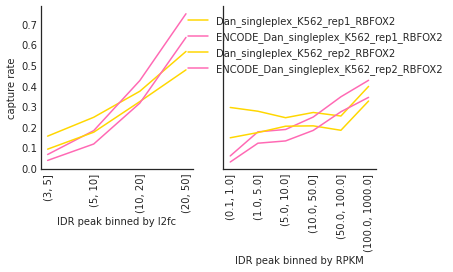

In [16]:

peaks = all_data.loc[(all_data['uid'].str.contains('RBFOX2'))
                               &(all_data['uid'].str.contains('K562'))
                              &(all_data['uid'].str.contains('singleplex'))]

f, ax = plt.subplots(1,2,figsize = (6,3), sharey = True)
binning = 'l2fc_bins'
for index, row in peaks.iterrows():
    try:
        bed = BedTool(row['bed_0']).filter(lambda x: float(x[3])>3).saveas()
        data = capture_rate_by_bin(k562_idr_annot, bed, to_bin = binning)
        color = 'hotpink' if 'ENCODE' in row['uid'] else 'gold'
        cap_rate = data.set_index(binning)['capture_rate'].dropna()
        cap_rate.plot(label = row['uid'], color = color, ax = ax[0])
        
    except Exception as e:
        print(e)
#ax[0].legend(bbox_to_anchor = (1.5,1))
ax[0].set_xlabel('IDR peak binned by l2fc')
ax[0].set_ylabel('capture rate')
ax[0].set_xticks(np.arange(cap_rate.shape[0]))
ax[0].set_xticklabels(cap_rate.index, rotation = 90)

binning = 'rpkm_bins'
for index, row in peaks.iterrows():
    try:
        bed = BedTool(row['bed_0']).filter(lambda x: float(x[3])>3).saveas()
        data = capture_rate_by_bin(k562_idr_annot, bed, to_bin = binning)
        color = 'hotpink' if 'ENCODE' in row['uid'] else 'gold'
        cap_rate = data.set_index(binning)['capture_rate'].dropna()
        cap_rate.plot(label = row['uid'], color = color, ax = ax[1])
        
    except Exception as e:
        print(e)
ax[1].legend(bbox_to_anchor = (1.5,1))
ax[1].set_xlabel('IDR peak binned by RPKM')
#ax[0].set_ylabel('capture rate')
ax[1].set_xticks(np.arange(cap_rate.shape[0]))
ax[1].set_xticklabels(cap_rate.index, rotation = 90)
sns.despine()

/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib

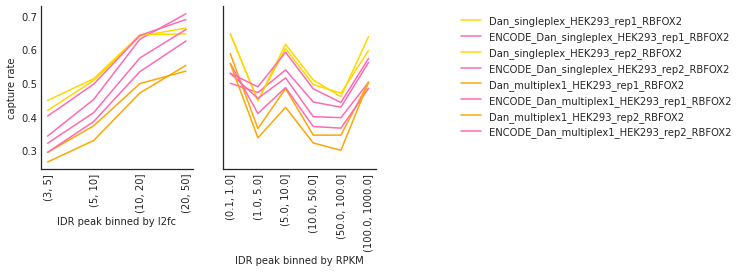

In [17]:

peaks = all_data.loc[(all_data['uid'].str.contains('RBFOX2'))
                               &(all_data['uid'].str.contains('HEK'))
                              ]

f, ax = plt.subplots(1,2,figsize = (6,3), sharey = True)
binning = 'l2fc_bins'
for index, row in peaks.iterrows():
    try:
        bed = BedTool(row['bed_0']).filter(lambda x: float(x[3])>3).saveas()
        data = capture_rate_by_bin(k562_idr_annot, bed, to_bin = binning)
        color = 'hotpink' if 'ENCODE' in row['uid'] else 'orange' if 'multiplex' in row['uid'] else 'gold'
        cap_rate = data.set_index(binning)['capture_rate'].dropna()
        cap_rate.plot(label = row['uid'], color = color, ax = ax[0])
        
    except Exception as e:
        print(e)
#ax[0].legend(bbox_to_anchor = (1.5,1))
ax[0].set_xlabel('IDR peak binned by l2fc')
ax[0].set_ylabel('capture rate')
ax[0].set_xticks(np.arange(cap_rate.shape[0]))
ax[0].set_xticklabels(cap_rate.index, rotation = 90)

binning = 'rpkm_bins'
for index, row in peaks.iterrows():
    try:
        bed = BedTool(row['bed_0']).filter(lambda x: float(x[3])>3).saveas()
        data = capture_rate_by_bin(k562_idr_annot, bed, to_bin = binning)
        color = 'hotpink' if 'ENCODE' in row['uid'] else 'orange' if 'multiplex' in row['uid'] else 'gold'
        cap_rate = data.set_index(binning)['capture_rate'].dropna()
        cap_rate.plot(label = row['uid'], color = color, ax = ax[1])
        
    except Exception as e:
        print(e)
ax[1].legend(bbox_to_anchor = (1.5,1))
ax[1].set_xlabel('IDR peak binned by RPKM')
#ax[0].set_ylabel('capture rate')
ax[1].set_xticks(np.arange(cap_rate.shape[0]))
ax[1].set_xticklabels(cap_rate.index, rotation = 90)
sns.despine()

/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib

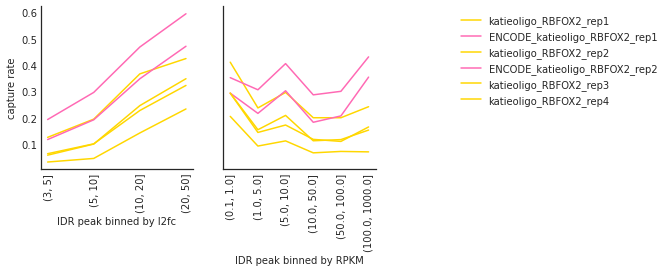

In [18]:

peaks = all_data.loc[(all_data['uid'].str.contains('RBFOX2'))
                               &(all_data['uid'].str.contains('katie'))
                              ]

f, ax = plt.subplots(1,2,figsize = (6,3), sharey = True)
binning = 'l2fc_bins'
for index, row in peaks.iterrows():
    try:
        bed = BedTool(row['bed_0']).filter(lambda x: float(x[3])>3).saveas()
        data = capture_rate_by_bin(k562_idr_annot, bed, to_bin = binning)
        color = 'hotpink' if 'ENCODE' in row['uid'] else 'gold'
        cap_rate = data.set_index(binning)['capture_rate'].dropna()
        cap_rate.plot(label = row['uid'], color = color, ax = ax[0])
        
    except Exception as e:
        print(e)
#ax[0].legend(bbox_to_anchor = (1.5,1))
ax[0].set_xlabel('IDR peak binned by l2fc')
ax[0].set_ylabel('capture rate')
ax[0].set_xticks(np.arange(cap_rate.shape[0]))
ax[0].set_xticklabels(cap_rate.index, rotation = 90)

binning = 'rpkm_bins'
for index, row in peaks.iterrows():
    try:
        bed = BedTool(row['bed_0']).filter(lambda x: float(x[3])>3).saveas()
        data = capture_rate_by_bin(k562_idr_annot, bed, to_bin = binning)
        color = 'hotpink' if 'ENCODE' in row['uid'] else 'gold'
        cap_rate = data.set_index(binning)['capture_rate'].dropna()
        cap_rate.plot(label = row['uid'], color = color, ax = ax[1])
        
    except Exception as e:
        print(e)
ax[1].legend(bbox_to_anchor = (1.5,1))
ax[1].set_xlabel('IDR peak binned by RPKM')
#ax[0].set_ylabel('capture rate')
ax[1].set_xticks(np.arange(cap_rate.shape[0]))
ax[1].set_xticklabels(cap_rate.index, rotation = 90)
sns.despine()

# full datasets

/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/hsher/miniconda3/envs/Metadensity/lib

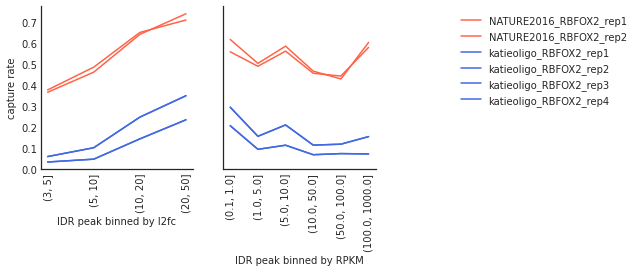

In [19]:

peaks = pd.concat([nature.loc[nature['RBP']=='RBFOX2'],
             katie.loc[katie['RBP']=='RBFOX2']], axis = 0)

f, ax = plt.subplots(1,2,figsize = (6,3), sharey = True)
binning = 'l2fc_bins'
for index, row in peaks.iterrows():
    try:
        bed = BedTool(row['bed_0']).filter(lambda x: float(x[3])>3).saveas()
        data = capture_rate_by_bin(k562_idr_annot, bed, to_bin = binning)
        color = 'royalblue' if 'katie' in row['uid'] else 'tomato'
        cap_rate = data.set_index(binning)['capture_rate'].dropna()
        cap_rate.plot(label = row['uid'], color = color, ax = ax[0])
        
    except Exception as e:
        print(e)
#ax[0].legend(bbox_to_anchor = (1.5,1))
ax[0].set_xlabel('IDR peak binned by l2fc')
ax[0].set_ylabel('capture rate')
ax[0].set_xticks(np.arange(cap_rate.shape[0]))
ax[0].set_xticklabels(cap_rate.index, rotation = 90)

binning = 'rpkm_bins'
for index, row in peaks.iterrows():
    try:
        bed = BedTool(row['bed_0']).filter(lambda x: float(x[3])>3).saveas()
        data = capture_rate_by_bin(k562_idr_annot, bed, to_bin = binning)
        color = 'royalblue' if 'katie' in row['uid'] else 'tomato'
        cap_rate = data.set_index(binning)['capture_rate'].dropna()
        cap_rate.plot(label = row['uid'], color = color, ax = ax[1])
        
    except Exception as e:
        print(e)
ax[1].legend(bbox_to_anchor = (1.5,1))
ax[1].set_xlabel('IDR peak binned by RPKM')
#ax[0].set_ylabel('capture rate')
ax[1].set_xticks(np.arange(cap_rate.shape[0]))
ax[1].set_xticklabels(cap_rate.index, rotation = 90)
sns.despine()